# QDA Image Recognition

In this exercise we will use training data to recognize a cat inside of an image. 

*Credit to Professor Stanley Chan (Purdue ECE and Statistics Professor) for the data used to train and test this model.*


First, lets import packages we need. 

In [ ]:
import pandas as pd
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image

If we are running this on Google Colab, we need to connect to our Google Drive Account and navigate to our folder. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Replace this to the path your data set is in
%cd '/content/drive/MyDrive/ML-Demo'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML-Demo


Now lets import our training data and our cat picture!

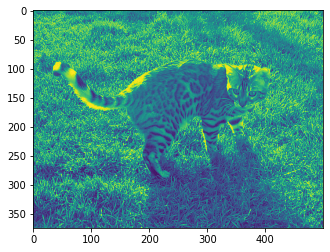

In [ ]:
## Some Samples of how cats looks like summarized into a text file for easier reading
train_cat = np.matrix(np.loadtxt('train_cat.txt', delimiter=','))
## Some Samples of how grass looks like summarized into a text file for easier reading
train_grass = np.matrix(np.loadtxt('train_grass.txt', delimiter=','))
Y = plt.imread('cat_grass.jpg') / 255
plt.imshow(Y)

Now we calculate the column values of each class ($\mu_1$ & $\mu_0$)

In [ ]:
mu_1 = np.mean(train_cat, axis = 1)
mu_0 = np.mean(train_grass, axis = 1)

We will also calculate the covariance matrices for each class ($\Sigma_1$ & $\Sigma_0$)

In [ ]:
sigma_0 = np.cov(train_grass)
sigma_1 = np.cov(train_cat)

Now we will calculate our prior probabilities $\pi_1$ and $\pi_0$ by simply adding up the sizes of our respective training sets and 

In [ ]:
K_1 = train_cat.shape[1]
K_0 = train_grass.shape[1]
pi_1 = K_1 / (K_0 + K_1)
pi_0 = K_0 / (K_0 + K_1)

Now lets actually calculate our descriminant score for each cell. 

As a reminder, here is the quadratic discriminant score equation: 

$$
\delta_k(x) = -\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)-\frac{1}{2}\log |\Sigma_k| + \log \pi_k
$$

To make this more computationall efficient, we are going to calculate some terms ahead of time. These terms are: 


*   $-.5\times \Sigma_k^{-1}$ for both the gass and the cat because inverting a matrix is computationally heavy.
*   $-.5\times\log|\Sigma_k|+ \log \pi_k$ for both classes so we don't have to keep taking determinants and logarithms within a loop. 




In [ ]:
sigma_0_inv = np.linalg.inv(sigma_0)
sigma_1_inv = np.linalg.inv(sigma_1)
lognorm_s1 = np.log(np.linalg.det(sigma_1))
lognorm_s0 = np.log(np.linalg.det(sigma_0))
sigma_0_inv_m = -.5 * sigma_0_inv
sigma_1_inv_m = -.5 * sigma_1_inv
pi_det_sum_1 = -.5 * lognorm_s1 + np.log(pi_1)
pi_det_sum_0 = -.5 * lognorm_s0 + np.log(pi_0)

Now we can try classifying each pixel in our cat picture. What we will do is take the $8px \times 8px$ around a given pixel, reshape it to a vector, then classify the pixel in question using the discriminant formula

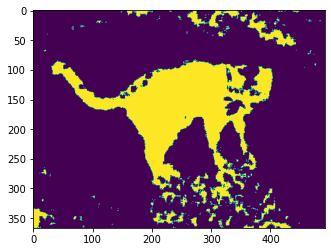

In [ ]:
M, N = Y.shape
prediction = np.zeros((M-8, N-8))
positives = 0
negatives = 0
true_positives = 0
false_positives = 0

for i in range(M-8):
  for j in range(N-8):
    block = Y[i:i+8, j:j+8]
    block = np.reshape(block, (64, 1))
    block_dif1 = block - mu_1
    block_dif0 = block - mu_0 
    a = block_dif1.T @ sigma_1_inv_m @ block_dif1 + pi_det_sum_1
    b = block_dif0.T @ sigma_0_inv_m @ block_dif0 + pi_det_sum_0
    if (a[0][0] > b[0][0]):
      prediction[i][j] = 1
    else:
      prediction[i][j] = 0

plt.imshow(prediction);

Our classifier did a pretty good job! Theres some mistakes in it (stuff like shadows, eyes, etc.), so lets try and use some metrics to quantify the error with metrics. First lets pull in the true labels for our cat picture:

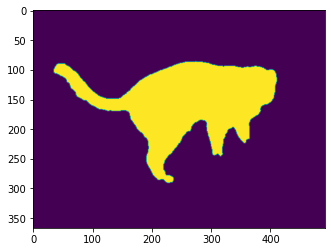

In [ ]:
truth = plt.imread('truth.png')
truth = truth[0:M-8, 0:N-8]
plt.imshow(truth)

Now lets calculate our confusion matrix values: True Positives, True Negatives, False Positives, and False Negatives

In [ ]:
false_positives= np.count_nonzero((truth - prediction) == -1)
false_negative = np.count_nonzero((truth - prediction) == 1)
true_positives = np.count_nonzero((truth + prediction) == 2)
true_negatives = np.count_nonzero((truth+prediction) == 0)

Now lets calculate accuracy, precision, and recall. As a reminder: 

$$
Accuracy = \frac{TP + TN}{TP+TN+FP+FN} = \text{How many we got right}
$$

$$
Precision = \frac{TP}{TP + FP} = \text{How many of our positive guesses were right}
$$

$$
Recall = \frac{TP}{TP+FN} = \text{How many true values did we guess right}
$$

In [ ]:
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negative)
precision = (true_positives) / (true_positives+false_positives)
recall = (true_positives) / (true_positives + false_negative)
print("Our Accuracy is: ", accuracy)
print("Our Precision is: ", precision)
print("Our Recall is: ", recall)

Our Accuracy is:  0.9153868688803506
Our Precision is:  0.7141515875725504
Our Recall is:  0.8346689721677252


Our accuracy is really good (91.5%) on this prediction! 

One property of our model that we can see by comparing the precision value (71.4%) to the recall value (83.5%) is that it has a higher tendency to classify pixels that should be negative as positive over doing the opposite. We can also see this in the image where our model classified the cat's shadow and grass in the background as the cat. 
